<a href="https://colab.research.google.com/github/ashutoshrabia/EEGNet/blob/main/LMDANet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.signal import butter, sosfiltfilt, sosfreqz
import matplotlib.pyplot as plt
from scipy import interp
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import os
from os import listdir
from os.path import isfile, join, isdir
import pickle
%matplotlib inline

In [ ]:
fs = 200.0     # 200 Hz sampling rate
lowcut = 1.0   # 0.1 Hz is the lowest frequency we will pass
highcut = 40.0 # 40 Hz is the highest frequency we will pass.


def butter_bandpass_filter(raw_data, fs, lowcut = 1.0, highcut = 40.0, order = 5):
  nyq = 0.5 * fs
  low = lowcut/nyq
  high = highcut/nyq
  sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
  filted_data = sosfiltfilt(sos, raw_data)
  return filted_data

In [ ]:
epoch_s = 0
epoch_e = 700
bl_s = 0
bl_e = 100


# number of mark per epoch
epoch_len = int((abs(epoch_s) + abs(epoch_e)) * (fs / 1000))

In [ ]:
train_subj_num = 16
test_subj_num = 10
stimulus_per_subj = 340
trial_per_subj = 5

channels = ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1',
    'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz',
    'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2',
    'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4',
    'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8',
    'PO7', 'POz', 'P08', 'O1', 'O2']

In [ ]:
import pandas as pd
train_labels = pd.read_csv('/content/drive/MyDrive/TrainLabels.csv')
sample_train_data = pd.read_csv('/content/drive/MyDrive/Data_S02_Sess01.csv')

In [ ]:
train_labels

,IdFeedBack,Prediction
0,S02_Sess01_FB001,1
1,S02_Sess01_FB002,1
2,S02_Sess01_FB003,0
3,S02_Sess01_FB004,0
4,S02_Sess01_FB005,1
...,...,...
5435,S26_Sess05_FB096,1
5436,S26_Sess05_FB097,0
5437,S26_Sess05_FB098,0
5438,S26_Sess05_FB099,0


In [ ]:
sample_train_data

,Time,Fp1,Fp2,AF7,AF3,AF4,AF8,F7,F5,F3,...,P4,P6,P8,PO7,POz,P08,O1,O2,EOG,FeedBackEvent
0,0.000,509.630351,609.688545,522.032153,454.102593,309.486489,524.804335,484.333383,587.340998,469.651564,...,295.834834,485.530586,411.161892,448.726097,99.151239,613.529369,428.286969,378.933590,-906.668876,0
1,0.005,864.521388,1038.483761,917.023604,775.970207,576.123392,934.962455,833.427809,996.070640,823.715523,...,528.713692,894.541770,735.827300,780.487458,239.407648,1067.349342,782.319229,711.286079,-1484.107119,0
2,0.010,754.576625,904.117869,803.235608,678.039830,489.573235,803.064230,706.392172,868.996293,717.565698,...,459.066586,870.217213,691.971456,689.656321,255.876323,933.617965,679.366071,699.014004,-1313.435186,0
3,0.015,801.593761,957.870867,834.026569,716.254450,519.006819,860.058239,769.518284,921.777695,756.664761,...,487.899954,905.564172,723.595463,723.944898,247.990115,992.180045,713.405603,714.734949,-1391.966973,0
4,0.020,769.054899,920.060832,811.596932,692.750986,494.315305,817.206918,727.500302,892.004312,729.239924,...,464.032652,769.258159,642.962959,687.852792,179.835749,949.832471,680.906506,607.057329,-1347.494166,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131996,659.980,326.493877,148.619853,367.120885,329.607132,568.760051,228.081535,386.342230,193.539354,263.262863,...,497.935681,136.897186,194.816484,235.516599,698.470304,115.904670,346.770258,-22.426859,-1179.103975,0
131997,659.985,299.398029,122.348935,317.862613,299.081994,540.210149,183.619873,354.533814,148.285289,208.522216,...,483.786225,87.994431,158.168639,220.717339,681.475238,69.722673,304.952629,-71.490262,-1245.844338,0
131998,659.990,313.987327,143.185940,352.162704,321.971403,551.396419,219.448645,345.700353,196.750843,253.721728,...,482.381296,130.181271,228.417928,229.943069,718.838360,110.441383,325.000921,62.368775,-1150.955909,0
131999,659.995,308.194641,121.836127,323.251844,313.754887,575.047001,202.242791,358.987420,165.629556,231.005230,...,511.892613,103.343795,229.027509,233.729526,782.742133,85.836597,327.645835,38.482607,-1304.594442,0


In [ ]:
train_list_arr = np.array(sorted(listdir('train')))
train_list_np = np.reshape(
    train_list_arr, (train_subj_num, trial_per_subj))
test_list_arr = np.array(sorted(listdir('test')))
test_list_np = np.reshape(
    test_list_arr, (test_subj_num, trial_per_subj))
print(train_list_np.shape, test_list_np.shape)

train_data_list = np.empty(
    (0, stimulus_per_subj, len(channels), epoch_len), float)
test_data_list = np.empty(
    (0, stimulus_per_subj, len(channels), epoch_len), float)
print(train_data_list.shape, test_data_list.shape)

In [ ]:
def generate_epoch(file_path, channels, fs, eeg_filter, stimulus_times=None, baseline=True,  epoch_s=0, epoch_e=700, bl_s=0, bl_e=100):
    # Generating epoch given csv file so that it should contain 'Time' column that represents timepoints, and the time should start from 0.
    # If your csv file does not have FeedBackEvent indicating the stimulus, you must pass stumulus_times.
    # Here we used a butter bandpass filter

    train_data = pd.read_csv(file_path)

    train_data.loc[:, 'Time'] = train_data.loc[:, 'Time']*1000
    raw_eeg = train_data[channels].values.T

    time_df = train_data['Time'].values
    train_data['index'] = train_data.index.values
    if stimulus_times is None:
        mark_indices = np.asarray(
            train_data[train_data['FeedBackEvent'] == 1].index).flatten()
    else:
        mark_indices = np.round(np.asarray(
            stimulus_times).flatten() * fs).astype(int)

    # We define the bounds of our epoch as well as our baseline

    # index in epoch_df where our baseline begins
    b_s = int((abs(epoch_s) + bl_s) * (fs / 1000))
    # index in epoch_df where our baseline ends
    b_e = int((abs(epoch_s) + bl_e) * (fs / 1000))

    # Let's calculate the length our epoch with our given sampling rate
    epoch_len = int((abs(epoch_s) + abs(epoch_e)) * (fs / 1000))

    # The number of indices before marker we want
    e_s = int((epoch_s * (fs / 1000)))
    # The number of indices after marker we want
    e_e = int((epoch_e * (fs / 1000)))

    # Epoch the data
    final_epoch = np.empty((mark_indices.shape[0], epoch_len, 0), float)
    for channel in channels:
        epoch = np.zeros(shape=(int(mark_indices.shape[0]), epoch_len))
        raw_eeg = train_data[channel].values

        clean_eeg = eeg_filter(raw_eeg, fs, lowcut, highcut, 5)

        for i, mark_idx in enumerate(mark_indices):
            # grab the appropriate samples around the stimulus onset
            epoch[i, :] = clean_eeg[mark_idx + e_s: mark_idx + e_e]

        # Baseline correction
        if baseline:
            for i in range(0, int(epoch.shape[0])):
                epoch[i, :] = epoch[i, :] - np.mean(epoch[i, b_s:b_e])

        # stack epoch of each channel
        final_epoch = np.dstack((final_epoch, epoch))
    final_epoch = np.swapaxes(final_epoch, 1, 2)
    return final_epoch

In [ ]:
if not isfile("train_data.npy"):
    for training_participant_id in range(train_subj_num):
        subject_dir_list = train_list_np[training_participant_id]
        subject_epoch = np.empty((0, len(channels), epoch_len), float)
        for trial_id in range(trial_per_subj):
            subject_dir = subject_dir_list[trial_id]
            data = generate_epoch('train/'+subject_dir, channels, fs,
                butter_bandpass_filter, epoch_s = epoch_s, epoch_e = epoch_e, bl_s = bl_s, bl_e = bl_e)
            subject_epoch = np.vstack((subject_epoch, data))
        subject_epoch = np.reshape(
            subject_epoch, (1, stimulus_per_subj, len(channels), epoch_len))
        train_data_list = np.vstack((train_data_list, subject_epoch))

    print('Epoched training data shape: ' + str(train_data_list.shape))

    for testing_participant_id in range(test_subj_num):
        subject_dir_list = test_list_np[testing_participant_id]
        subject_epoch = np.empty((0, len(channels), epoch_len), float)
        for trial_id in range(trial_per_subj):
            subject_dir = subject_dir_list[trial_id]
            data = generate_epoch('test/'+subject_dir, channels, fs,
                butter_bandpass_filter, epoch_s = epoch_s, epoch_e = epoch_e, bl_s = bl_s, bl_e = bl_e)
            subject_epoch = np.vstack((subject_epoch, data))
        subject_epoch = np.reshape(
            subject_epoch, (1, stimulus_per_subj, len(channels), epoch_len))
        test_data_list = np.vstack((test_data_list, subject_epoch))

    print('Epoched testing data shape: ' + str(test_data_list.shape))

    np.save('train_data.npy', train_data_list)
    np.save('test_data.npy', test_data_list)

In [ ]:
train_data_list = np.load('/content/drive/MyDrive/train_data.npy')
test_data_list = np.load('/content/drive/MyDrive/test_data.npy')
print('Epoched training data shape: ' + str(train_data_list.shape))
print('Epoched testing data shape: ' + str(test_data_list.shape))

Epoched training data shape: (16, 340, 56, 140)
Epoched testing data shape: (10, 340, 56, 140)


# LMDANet


In [ ]:
!pip install torchinfo

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import torchinfo
!pip install pyriemann
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 1.4 MB/s eta 0:00:00


In [ ]:
Y_train = pd.read_csv('/content/drive/MyDrive/TrainLabels.csv')['Prediction'].values

In [ ]:
if not isfile('X_train.npy'):
    XC = XdawnCovariances(nfilter=5) # our transformer
    TS = TangentSpace(metric='riemann')
    test_data = np.reshape(test_data_list,
    (test_subj_num * stimulus_per_subj, len(channels), epoch_len))
    train_data = np.reshape(train_data_list,
    (train_subj_num * stimulus_per_subj, len(channels), epoch_len))

    X_train = XC.fit_transform(train_data, Y_train)
    X_train = TS.fit_transform(X_train)
    X_test = XC.transform(test_data)
    X_test = TS.transform(X_test)

    np.save('X_train', X_train)
    np.save('X_test', X_test)
    np.save('Y_train', Y_train)

In [ ]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
Y_train = np.load('Y_train.npy')

# Only used for scoring
Y_test = np.reshape(pd.read_csv('/content/drive/MyDrive/true_labels.csv', header=None).values, 3400)

In [ ]:
print('Transformed training data shape: ' + str(X_train.shape))
print('Training label shape: ' + str(Y_train.shape))
print('Transformed testing data shape: ' + str(X_test.shape))
print('Testing label shape: ' + str(Y_test.shape))

Transformed training data shape: (5440, 210)
Training label shape: (5440,)
Transformed testing data shape: (3400, 210)
Testing label shape: (3400,)


In [ ]:
train_data_list = np.load('/content/drive/MyDrive/train_data.npy')
test_data_list = np.load('/content/drive/MyDrive/test_data.npy')
# Reshape the data
train_data = train_data_list.reshape(-1, 1, 56, 140)
test_data = test_data_list.reshape(-1, 1, 56, 140)

# Convert data to PyTorch tensors
train_data = torch.tensor(train_data, dtype=torch.float32)
test_data = torch.tensor(test_data, dtype=torch.float32)
train_labels = torch.tensor(Y_train, dtype=torch.long)
test_labels = torch.tensor(Y_test, dtype=torch.long)

# Create DataLoader
batch_size = 32
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the LMDA model
class EEGDepthAttention(nn.Module):
    def __init__(self, W, C, k=7):
        super(EEGDepthAttention, self).__init__()
        self.C = C
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, W))
        self.conv = nn.Conv2d(1, 1, kernel_size=(k, 1), padding=(k // 2, 0), bias=True)
        self.softmax = nn.Softmax(dim=-2)

    def forward(self, x):
        x_pool = self.adaptive_pool(x)
        x_transpose = x_pool.transpose(-2, -3)
        y = self.conv(x_transpose)
        y = self.softmax(y)
        y = y.transpose(-2, -3)
        return y * self.C * x
accuracy = 0.1
class LMDA(nn.Module):
    def __init__(self, chans=22, samples=1125, num_classes=4, depth=9, kernel=75, channel_depth1=24, channel_depth2=9,
                ave_depth=1, avepool=5):
        super(LMDA, self).__init__()
        self.ave_depth = ave_depth
        self.channel_weight = nn.Parameter(torch.randn(depth, 1, chans), requires_grad=True)
        nn.init.xavier_uniform_(self.channel_weight.data)

        self.time_conv = nn.Sequential(
            nn.Conv2d(depth, channel_depth1, kernel_size=(1, 1), groups=1, bias=False),
            nn.BatchNorm2d(channel_depth1),
            nn.Conv2d(channel_depth1, channel_depth1, kernel_size=(1, kernel),
                      groups=channel_depth1, bias=False),
            nn.BatchNorm2d(channel_depth1),
            nn.GELU(),
        )

        self.chanel_conv = nn.Sequential(
            nn.Conv2d(channel_depth1, channel_depth2, kernel_size=(1, 1), groups=1, bias=False),
            nn.BatchNorm2d(channel_depth2),
            nn.Conv2d(channel_depth2, channel_depth2, kernel_size=(chans, 1), groups=channel_depth2, bias=False),
            nn.BatchNorm2d(channel_depth2),
            nn.GELU(),
        )

        self.norm = nn.Sequential(
            nn.AvgPool3d(kernel_size=(1, 1, avepool)),
            nn.Dropout(p=0.65),
        )

        out = torch.ones((1, depth, chans, samples))  # Adjusted to have depth dimension
        out = torch.einsum('bdcw, hdc->bhcw', out, self.channel_weight)
        out = self.time_conv(out)
        N, C, H, W = out.size()

        self.depthAttention = EEGDepthAttention(W, C, k=7)

        out = self.chanel_conv(out)
        out = self.norm(out)
        n_out_time = out.cpu().data.numpy().shape
        print('In ShallowNet, n_out_time shape: ', n_out_time)
        self.classifier = nn.Linear(n_out_time[-1]*n_out_time[-2]*n_out_time[-3], num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = torch.einsum('bdcw, hdc->bhcw', x, self.channel_weight)
        x_time = self.time_conv(x)
        x_time = self.depthAttention(x_time)
        x = self.chanel_conv(x_time)
        x = self.norm(x)
        features = torch.flatten(x, 1)
        cls = self.classifier(features)
        return cls


In [ ]:
# Instantiate the model
num_classes = len(np.unique(train_labels))
model = LMDA(chans=56, samples=140, num_classes=num_classes, depth=1, kernel=5, channel_depth1=24, channel_depth2=9, ave_depth=1, avepool=5)

# Print the model summary
torchinfo.summary(model, input_size=(32, 1, 56, 140))

In ShallowNet, n_out_time shape:  (1, 9, 1, 27)


Layer (type:depth-idx)                   Output Shape              Param #
LMDA                                     [32, 2]                   56
├─Sequential: 1-1                        [32, 24, 56, 136]         --
│    └─Conv2d: 2-1                       [32, 24, 56, 140]         24
│    └─BatchNorm2d: 2-2                  [32, 24, 56, 140]         48
│    └─Conv2d: 2-3                       [32, 24, 56, 136]         120
│    └─BatchNorm2d: 2-4                  [32, 24, 56, 136]         48
│    └─GELU: 2-5                         [32, 24, 56, 136]         --
├─EEGDepthAttention: 1-2                 [32, 24, 56, 136]         --
│    └─AdaptiveAvgPool2d: 2-6            [32, 24, 1, 136]          --
│    └─Conv2d: 2-7                       [32, 1, 24, 136]          8
│    └─Softmax: 2-8                      [32, 1, 24, 136]          --
├─Sequential: 1-3                        [32, 9, 1, 136]           --
│    └─Conv2d: 2-9                       [32, 9, 56, 136]          216
│    └─BatchNo

Epoch [1/10], Loss: 0.5957
Epoch [2/10], Loss: 0.5851
Epoch [3/10], Loss: 0.5707
Epoch [4/10], Loss: 0.5695
Epoch [5/10], Loss: 0.5617
Epoch [6/10], Loss: 0.5583
Epoch [7/10], Loss: 0.5529
Epoch [8/10], Loss: 0.5444
Epoch [9/10], Loss: 0.5463
Epoch [10/10], Loss: 0.5416


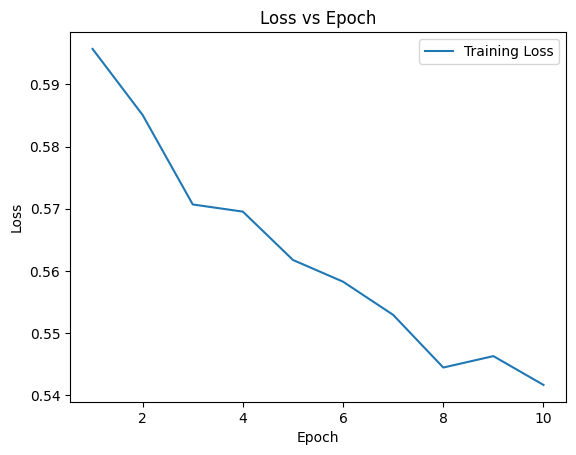

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-3)
num_epochs = 10

# List to store loss values
epoch_losses = []

# Training loop
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    average_loss = running_loss / len(train_loader)
    epoch_losses.append(average_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')

# Plotting the loss vs epoch
plt.figure()
plt.plot(range(1, num_epochs + 1), epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model
model.eval()
all_targets = []
all_predictions = []
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        all_targets.extend(target.numpy())
        all_predictions.extend(predicted.numpy())

accuracy += accuracy_score(all_targets, all_predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 82.32%


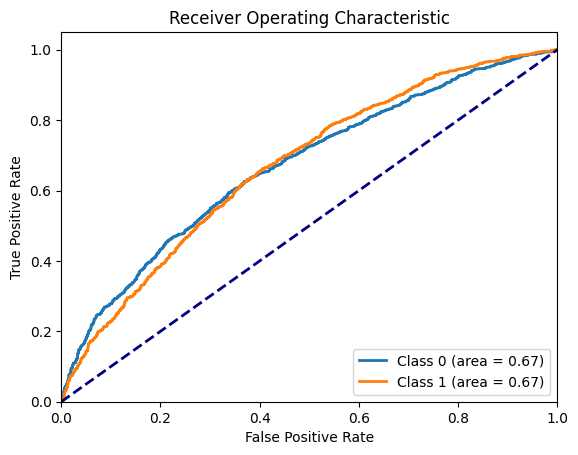

In [ ]:
# Plot ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Convert labels to one-hot encoding for ROC curve
num_classes = len(np.unique(train_labels))
all_targets_onehot = np.eye(num_classes)[all_targets]

# Get scores for ROC curve
all_scores = []
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        scores = torch.softmax(model(data), dim=1).numpy()
        all_scores.extend(scores)

all_scores = np.array(all_scores)

# Plot ROC curve for each class
plt.figure()
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(all_targets_onehot[:, i], all_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

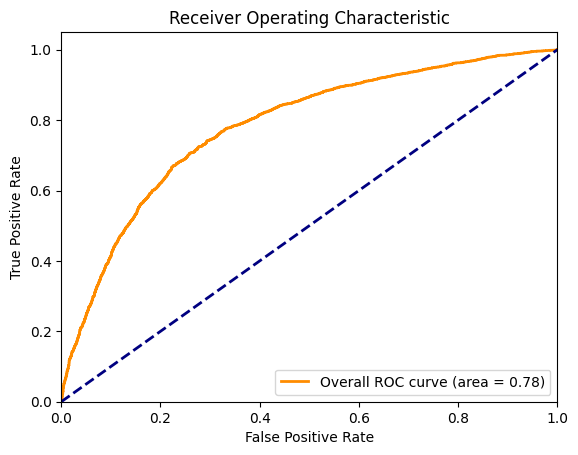

In [ ]:
fpr, tpr, _ = roc_curve(all_targets_onehot.ravel(), all_scores.ravel())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Overall ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Epoch [1/10], Loss: 0.5415
Epoch [2/10], Loss: 0.5450
Epoch [3/10], Loss: 0.5411
Epoch [4/10], Loss: 0.5433
Epoch [5/10], Loss: 0.5401
Epoch [6/10], Loss: 0.5369
Epoch [7/10], Loss: 0.5366
Epoch [8/10], Loss: 0.5336
Epoch [9/10], Loss: 0.5359
Epoch [10/10], Loss: 0.5293


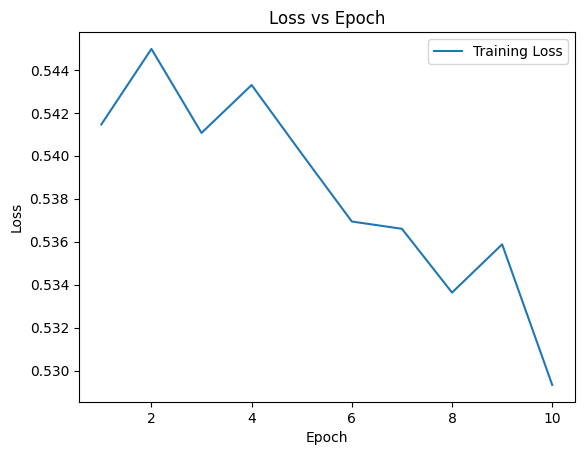

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-3)
num_epochs = 10

# List to store loss values
epoch_losses = []

# Training loop
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    average_loss = running_loss / len(train_loader)
    epoch_losses.append(average_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')

# Plotting the loss vs epoch
plt.figure()
plt.plot(range(1, num_epochs + 1), epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model
model.eval()
all_targets = []
all_predictions = []
accuracy = 0.0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        all_targets.extend(target.numpy())
        all_predictions.extend(predicted.numpy())

accuracy += accuracy_score(all_targets, all_predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 72.94%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import numpy as np

# Define the LMDA model
class ImprovedLMDA(nn.Module):
    def __init__(self, chans=56, samples=140, num_classes=2):
        super(ImprovedLMDA, self).__init__()
        self.conv1 = nn.Conv2d(1, 24, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
        self.conv2 = nn.Conv2d(24, 9, kernel_size=(chans, 1), stride=(1, 1), padding=(0, 0))
        self.pool = nn.MaxPool2d(kernel_size=(1, 5), stride=(1, 5))
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(9 * int((samples - 4) / 5), 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.gelu(self.conv1(x))
        x = self.pool(x)
        x = F.gelu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = F.gelu(self.fc1(x))
        x = self.fc2(x)
        return x


# Create DataLoader
batch_size = 32
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Instantiate the model
model = ImprovedLMDA()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

# Training parameters
num_epochs = 100
train_losses = []
val_losses = []

# Training loop with validation
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    average_train_loss = running_loss / len(train_loader)
    train_losses.append(average_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}')

    # Validation steps
    model.eval()
    val_running_loss = 0.0
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            loss = criterion(output, target)
            val_running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            all_targets.extend(target.numpy())
            all_predictions.extend(predicted.numpy())

    average_val_loss = val_running_loss / len(test_loader)
    val_losses.append(average_val_loss)
    scheduler.step(average_val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {average_val_loss:.4f}')
    accuracy = accuracy_score(all_targets, all_predictions)
    roc_auc = roc_auc_score(all_targets, all_predictions)
    print(f'Validation Accuracy: {accuracy * 100:.2f}%, ROC AUC: {roc_auc:.4f}')

# Plotting the loss vs epoch
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

# Evaluate the final model
model.eval()
all_targets = []
all_predictions = []
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        all_targets.extend(target.numpy())
        all_predictions.extend(predicted.numpy())

final_accuracy = accuracy_score(all_targets, all_predictions)
final_roc_auc = roc_auc_score(all_targets, all_predictions)
print(f'Final Accuracy: {final_accuracy * 100:.2f}%, Final ROC AUC: {final_roc_auc:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x45 and 243x256)

# Temporal Attention

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import torchinfo

# Replace these with your actual data loading code
train_data_list = np.load('/content/drive/MyDrive/train_data.npy')
test_data_list = np.load('/content/drive/MyDrive/test_data.npy')

# Reshape the data
train_data = train_data_list.reshape(-1, 1, 56, 140)
test_data = test_data_list.reshape(-1, 1, 56, 140)

# Convert data to PyTorch tensors
train_data = torch.tensor(train_data, dtype=torch.float32)
test_data = torch.tensor(test_data, dtype=torch.float32)
train_labels = torch.tensor(Y_train, dtype=torch.long)
test_labels = torch.tensor(Y_test, dtype=torch.long)

# Create DataLoader
batch_size = 32
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the EEGDepthAttention model
class EEGDepthAttention(nn.Module):
    def __init__(self, W, C, k=7):
        super(EEGDepthAttention, self).__init__()
        self.C = C
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, W))
        self.conv = nn.Conv2d(1, 1, kernel_size=(k, 1), padding=(k // 2, 0), bias=True)
        self.softmax = nn.Softmax(dim=-2)

    def forward(self, x):
        x_pool = self.adaptive_pool(x)
        x_transpose = x_pool.transpose(-2, -3)
        y = self.conv(x_transpose)
        y = self.softmax(y)
        y = y.transpose(-2, -3)
        return y * self.C * x

class TemporalAttention(nn.Module):
    def __init__(self, chans, samples, kernel=7):
        super(TemporalAttention, self).__init__()
        self.conv = nn.Conv1d(chans, chans, kernel_size=kernel, padding=kernel//2, groups=chans)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = x.squeeze(1)  # Remove the single channel dimension
        attn_weights = self.conv(x)
        attn_weights = self.softmax(attn_weights)
        x = x * attn_weights
        x = x.unsqueeze(1)  # Add the single channel dimension back
        return x

class LMDA(nn.Module):
    def __init__(self, chans=22, samples=1125, num_classes=4, depth=9, kernel=75, channel_depth1=24, channel_depth2=9,
                ave_depth=1, avepool=5):
        super(LMDA, self).__init__()
        self.ave_depth = ave_depth
        self.channel_weight = nn.Parameter(torch.randn(depth, 1, chans), requires_grad=True)
        nn.init.xavier_uniform_(self.channel_weight.data)

        self.temporal_attention = TemporalAttention(chans, samples)

        self.time_conv = nn.Sequential(
            nn.Conv2d(depth, channel_depth1, kernel_size=(1, 1), groups=1, bias=False),
            nn.BatchNorm2d(channel_depth1),
            nn.Conv2d(channel_depth1, channel_depth1, kernel_size=(1, kernel),
                      groups=channel_depth1, bias=False),
            nn.BatchNorm2d(channel_depth1),
            nn.GELU(),
        )

        self.chanel_conv = nn.Sequential(
            nn.Conv2d(channel_depth1, channel_depth2, kernel_size=(1, 1), groups=1, bias=False),
            nn.BatchNorm2d(channel_depth2),
            nn.Conv2d(channel_depth2, channel_depth2, kernel_size=(chans, 1), groups=channel_depth2, bias=False),
            nn.BatchNorm2d(channel_depth2),
            nn.GELU(),
        )

        self.norm = nn.Sequential(
            nn.AvgPool3d(kernel_size=(1, 1, avepool)),
            nn.Dropout(p=0.65),
        )

        out = torch.ones((1, depth, chans, samples))  # Adjusted to have depth dimension
        out = torch.einsum('bdcw, hdc->bhcw', out, self.channel_weight)
        out = self.time_conv(out)
        N, C, H, W = out.size()

        self.depthAttention = EEGDepthAttention(W, C, k=7)

        out = self.chanel_conv(out)
        out = self.norm(out)
        n_out_time = out.cpu().data.numpy().shape
        print('In ShallowNet, n_out_time shape: ', n_out_time)
        self.classifier = nn.Linear(n_out_time[-1]*n_out_time[-2]*n_out_time[-3], num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = torch.einsum('bdcw, hdc->bhcw', x, self.channel_weight)
        x = self.temporal_attention(x)  # Apply temporal attention here
        x_time = self.time_conv(x)
        x_time = self.depthAttention(x_time)
        x = self.chanel_conv(x_time)
        x = self.norm(x)
        features = torch.flatten(x, 1)
        cls = self.classifier(features)
        return cls

# Instantiate the model
num_classes = len(np.unique(train_labels))
model = LMDA(chans=56, samples=140, num_classes=num_classes, depth=1, kernel=5, channel_depth1=24, channel_depth2=9, ave_depth=1, avepool=5)

# Print the model summary
torchinfo.summary(model, input_size=(32, 1, 56, 140))

In ShallowNet, n_out_time shape:  (1, 9, 1, 27)


Layer (type:depth-idx)                   Output Shape              Param #
LMDA                                     [32, 2]                   56
├─TemporalAttention: 1-1                 [32, 1, 56, 140]          --
│    └─Conv1d: 2-1                       [32, 56, 140]             448
│    └─Softmax: 2-2                      [32, 56, 140]             --
├─Sequential: 1-2                        [32, 24, 56, 136]         --
│    └─Conv2d: 2-3                       [32, 24, 56, 140]         24
│    └─BatchNorm2d: 2-4                  [32, 24, 56, 140]         48
│    └─Conv2d: 2-5                       [32, 24, 56, 136]         120
│    └─BatchNorm2d: 2-6                  [32, 24, 56, 136]         48
│    └─GELU: 2-7                         [32, 24, 56, 136]         --
├─EEGDepthAttention: 1-3                 [32, 24, 56, 136]         --
│    └─AdaptiveAvgPool2d: 2-8            [32, 24, 1, 136]          --
│    └─Conv2d: 2-9                       [32, 1, 24, 136]          8
│    └─Softmax

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-3)
num_epochs = 10

# List to store loss values
epoch_losses = []

# Training loop
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    average_loss = running_loss / len(train_loader)
    epoch_losses.append(average_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')

Epoch [1/10], Loss: 0.6106
Epoch [2/10], Loss: 0.5998
Epoch [3/10], Loss: 0.5944
Epoch [4/10], Loss: 0.5846
Epoch [5/10], Loss: 0.5778
Epoch [6/10], Loss: 0.5735
Epoch [7/10], Loss: 0.5720
Epoch [8/10], Loss: 0.5632
Epoch [9/10], Loss: 0.5576
Epoch [10/10], Loss: 0.5595


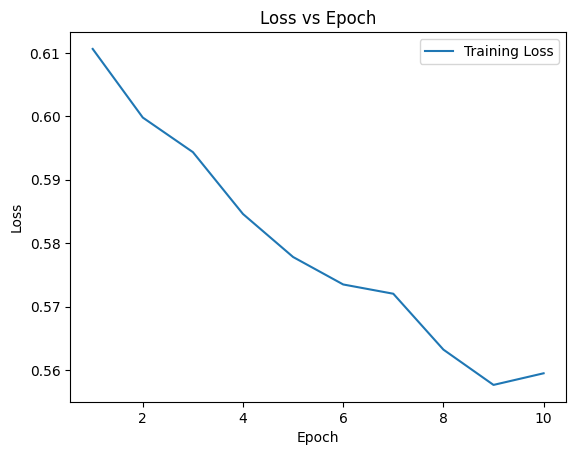

Accuracy: 71.62%


In [ ]:
plt.figure()
plt.plot(range(1, num_epochs + 1), epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

# Evaluate the model
model.eval()
all_targets = []
all_predictions = []
all_probs = []
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        probs = nn.functional.softmax(output, dim=1)
        _, predicted = torch.max(output.data, 1)
        all_targets.extend(target.numpy())
        all_predictions.extend(predicted.numpy())
        all_probs.extend(probs.numpy()[:, 1])  # Get probabilities for class 1

# Calculate accuracy
accuracy = accuracy_score(all_targets, all_predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

AUC: 0.6795


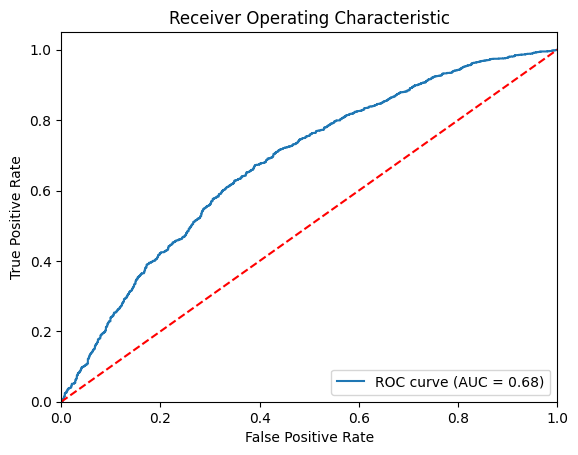

In [ ]:
# Calculate AUC
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(all_targets, all_probs)
print(f'AUC: {auc_score:.4f}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(all_targets, all_probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()